In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1337)  # for reproducibility

from sklearn.datasets import make_swiss_roll

from theano import function

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Layer
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

from seya.layers.variational import VariationalDense as VAE
from seya.layers.convolutional import GlobalPooling2D
from seya.utils import apply_model
from seya.layers.regularization import ITLRegularizer
from seya.parzen import ParzenWindows

from agnez import grid2d, embedding2dplot

batch_size = 100
nb_epoch = 100
code_size = 3

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 7
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype("float32").reshape((-1, 784))
X_test = X_test.astype("float32").reshape((-1, 784))
X_train /= 255
X_test /= 255

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_valid = X_train[50000:]
Y_valid = Y_train[50000:]
X_train = X_train[:50000]
Y_train = Y_train[:50000]

Using Theano backend.
X_train shape: (60000, 784)
60000 train samples
10000 test samples


Using gpu device 0: GeForce GTX 680 (CNMeM is disabled)


In [2]:
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
rng = RandomStreams()

def swiss_roll(size, noise=1, rng=rng):
    u = rng.uniform(size=(size[0], 1))
    t = 1.5 * np.pi * (1 + 2 * u)
    x = t * T.cos(t)
    # y = 21 * u2
    z = t * T.sin(t)

    X = K.concatenate([x, z], axis=-1)
    X += noise * rng.uniform(size=(size[0], 2))
    t = np.squeeze(t)
    return X

def laplace(size, rng=rng):
    u = rng.uniform(size=size)
    sgn = T.switch(T.gt(rng.uniform(size=size), .5), -1, 1)
    X = T.log(1 - u) * sgn
    return X

from theano import as_op
import theano
def infer_shape_numpy_dot(node, input_shapes):
    print(node)
    return node

@as_op(itypes=[theano.tensor.TensorType('float32', 'vector')],
       otypes=[theano.tensor.dmatrix], infer_shape=infer_shape_numpy_dot)
def laplace(shape):
    return np.random.laplace(shape.astype('int')).astype('float32')

In [3]:
enc = Sequential()
enc.add(Dense(1000, input_dim=784))
enc.add(Activation('tanh'))
enc.add(BN())
enc.add(Dense(1000))
enc.add(Activation('tanh'))
enc.add(BN())

enc.add(Dense(code_size))
enc.add(Activation('linear'))

# Default prior is a guassian with mean=0, std=5
enc.add(ITLRegularizer(distance='euclidean', scale=1., ksize=5.,
#                       #distribution=swiss_roll
                      ))
#enc.add(VAE(code_size, 100))

In [4]:
dec = Sequential()

dec.add(Dense(1000, input_dim=code_size, activation='tanh'))
#dec.add(Activation('tanh'))
#dec.add(ITLRegularizer(distance='entropy', scale=1., ksize=5))
#dec.add(BN())
dec.add(Dense(1000, activation='tanh'))
#dec.add(Activation('tanh'))
#dec.add(BN())
#dec.add(ITLRegularizer(distance='entropy', scale=1., ksize=5))

dec.add(Dense(784))
dec.add(Activation('sigmoid'))

In [5]:
model = Sequential()
model.add(enc)
model.add(dec)

model.compile(loss='mse', optimizer='adam')

In [6]:
    cbk = ModelCheckpoint('itl.hdf5', save_best_only=True, verbose=True)

    #try:
    model.fit(X_train, X_train.reshape((-1, 784)), batch_size=batch_size, nb_epoch=100, verbose=2,
          validation_data=(X_valid, X_valid.reshape((-1, 784))),
          callbacks=[cbk]
         )
    #except:
    #pass

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
3s - loss: 0.0881 - val_loss: 0.0469
Epoch 00000: val_loss improved from inf to 0.04692, saving model to itl.hdf5
Epoch 2/100
3s - loss: 0.0478 - val_loss: 0.0399
Epoch 00001: val_loss improved from 0.04692 to 0.03993, saving model to itl.hdf5
Epoch 3/100
3s - loss: 0.0430 - val_loss: 0.0369
Epoch 00002: val_loss improved from 0.03993 to 0.03686, saving model to itl.hdf5
Epoch 4/100
3s - loss: 0.0404 - val_loss: 0.0354
Epoch 00003: val_loss improved from 0.03686 to 0.03539, saving model to itl.hdf5
Epoch 5/100
3s - loss: 0.0390 - val_loss: 0.0346
Epoch 00004: val_loss improved from 0.03539 to 0.03457, saving model to itl.hdf5
Epoch 6/100
3s - loss: 0.0380 - val_loss: 0.0337
Epoch 00005: val_loss improved from 0.03457 to 0.03365, saving model to itl.hdf5
Epoch 7/100
3s - loss: 0.0373 - val_loss: 0.0330
Epoch 00006: val_loss improved from 0.03365 to 0.03297, saving model to itl.hdf5
Epoch 8/100
3s - loss: 0.0367 - val_loss: 0.

# Load best model

In [7]:
#model.load_weights('itl.hdf5')

# Sample (for visualization purposes)

In [9]:
X = K.placeholder(ndim=2)
Y = dec(X)
F = function([X], Y, allow_input_downcast=True)

(144, 3)


(-0.5, 348.5, 348.5, -0.5)

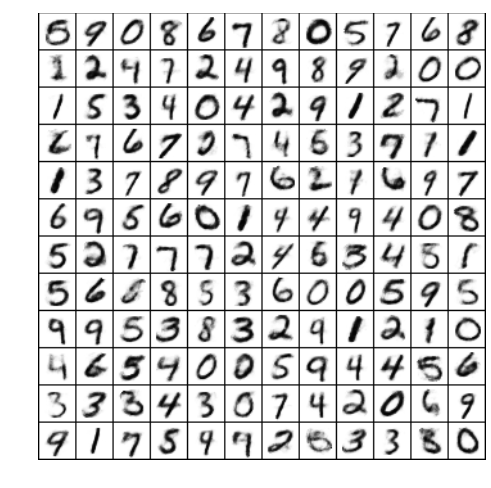

In [28]:
plt.figure(figsize=(8, 8))
x = np.random.normal(0, 5, size=(144, code_size))
# x = np.random.uniform(-10, 10, size=(100, code_size))
#x = make_swiss_roll(100, noise=1.)[0]; x = x[:, [0, 2]]
#x = np.random.laplace(size=(100, code_size))
print(x.shape)
y = F(x)
I = grid2d(y.reshape((-1, 784)))
plt.imshow(-I, cmap='gray')
plt.axis('off')

# Visualize first layer

In [17]:
W = np.asarray(K.eval(enc.layers[0].W)).T
I = grid2d(W[:100])

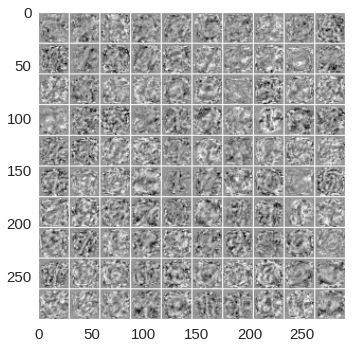

In [18]:
plt.imshow(I)

# Visualize last layer

In [19]:
W = np.asarray(K.eval(dec.layers[-2].W))
I = grid2d(W[:100])

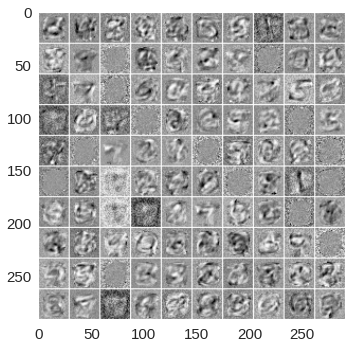

In [20]:
plt.imshow(I)

# Log-likelihood

Protocol:

We need to figure the best sigma (kernel size for the Parzen estimator) here. We sample randomly from the model
and test several values of sigma on the validation dataset (X_valid). The one with best results should be applied to the test set (X_test).

In [21]:
samples = np.zeros((10000, 784))
for i in range(100):
    x = np.random.normal(0, 5, size=(100, code_size))
    #x = make_swiss_roll(10000, noise=1.)[0]; x = x[:, [0, 2]]
    #x = np.random.laplace(size=(100, code_size))
    y = F(x)
    #y -= y.min()
    #y /= y.max()
    samples[i*100:(i+1)*100] = y

In [22]:
pw = ParzenWindows(samples=samples, sigma=.16)

In [23]:
pw.get_ll(X_test) 

300.27303261578083

In [ ]:
nll = []
sigmas = np.arange(.01, 5, .05)
for s in sigmas:
    pw = ParzenWindows(samples=samples, sigma=s)
    v = pw.get_ll(X_valid) 
    nll.append(v)
    print(v)

In [ ]:
best_s = sigmas[np.asarray(nll).argmax()]
pw = ParzenWindows(samples=samples, sigma=best_s)
pw.get_ll(X_test) 

In [ ]:
best_s

In [ ]:
# repeat best 10 times

mcruns = np.zeros(10)
for k in range(10):
    samples = np.zeros((10000, 784))
    for i in range(100):
        x = np.random.normal(0, 5, size=(100, code_size))
        #x = make_swiss_roll(10000, noise=1.)[0]; x = x[:, [0, 2]]
        #x = np.random.laplace(size=(100, code_size))
        y = F(x)
        #y -= y.min()
        #y /= y.max()
        samples[i*100:(i+1)*100] = y
    best_s = sigmas[np.asarray(nll).argmax()]
    pw = ParzenWindows(samples=samples, sigma=best_s)
    mcruns[k] = pw.get_ll(X_test) 

print(mcruns.mean())
print(mcruns.std())